In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [17]:
# 1. Load Data
df = pd.read_csv("5000_cleaned_combined2.csv")

In [18]:
# 2. Encode label (multi-class)
le = LabelEncoder()
y = le.fit_transform(df['label'])
X_text = df['cleaned_content']

In [19]:
# 3. TF-IDF vectorization (max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

In [20]:
# Tampilkan distribusi label
print("Jumlah data per label:")
print(df['label'].value_counts())

Jumlah data per label:
label
easeofuse             1214
reliability           1041
informationquality     806
nonquality             795
responsiveness         672
webdesign              306
privacy                166
Name: count, dtype: int64


In [21]:
# 4. Siapkan cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# 5. Definisikan model dan grid parameter
# LINEAR
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
param_grid = {
    'C': [0.1, 1, 10, 100] 
}

In [23]:
# RBF
# svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
# }

In [24]:
# POLY
# svm = SVC(kernel='poly', class_weight='balanced', random_state=42)
# param_grid = {
#     'C': [0.1, 1, 10],
#     'degree': [2, 3, 4],
#     'gamma': ['scale', 0.01, 0.1],
#     'coef0': [0, 1]
# }

In [25]:
# SIGMOID
# svm = SVC(kernel='sigmoid', class_weight='balanced', random_state=42)
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': ['scale', 0.01, 0.1],
#     'coef0': [0, 1]
# }

In [26]:
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro', 
    n_jobs=-1,
    verbose=1
)

# Jalankan grid search
print("Melakukan Grid Search...")
grid_search.fit(X_tfidf, y)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-macro score: {grid_search.best_score_:.4f}")

Melakukan Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits



Best parameters: {'C': 1}
Best cross-validation F1-macro score: 0.7708


In [27]:
# 7. Dapatkan prediksi untuk SELURUH dataset menggunakan best estimator
# Gunakan cross_val_predict agar setiap sampel diprediksi pada fold yang tidak melatihnya
y_pred = cross_val_predict(grid_search.best_estimator_, X_tfidf, y, cv=cv)

# 8. Evaluasi global
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, average='macro')
rec = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

print(f"\n=== METRIK GLOBAL ===")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1-score   : {f1:.4f}")

# Classification report lengkap
print("\n=== Classification Report (Global) ===")
print(classification_report(y, y_pred, target_names=le.classes_))


=== METRIK GLOBAL ===
Accuracy   : 0.7732
Precision  : 0.7842
Recall     : 0.7644
F1-score   : 0.7725

=== Classification Report (Global) ===
                    precision    recall  f1-score   support

         easeofuse       0.82      0.78      0.80      1214
informationquality       0.83      0.78      0.80       806
        nonquality       0.77      0.90      0.83       795
           privacy       0.75      0.64      0.69       166
       reliability       0.65      0.67      0.66      1041
    responsiveness       0.79      0.77      0.78       672
         webdesign       0.88      0.80      0.84       306

          accuracy                           0.77      5000
         macro avg       0.78      0.76      0.77      5000
      weighted avg       0.78      0.77      0.77      5000



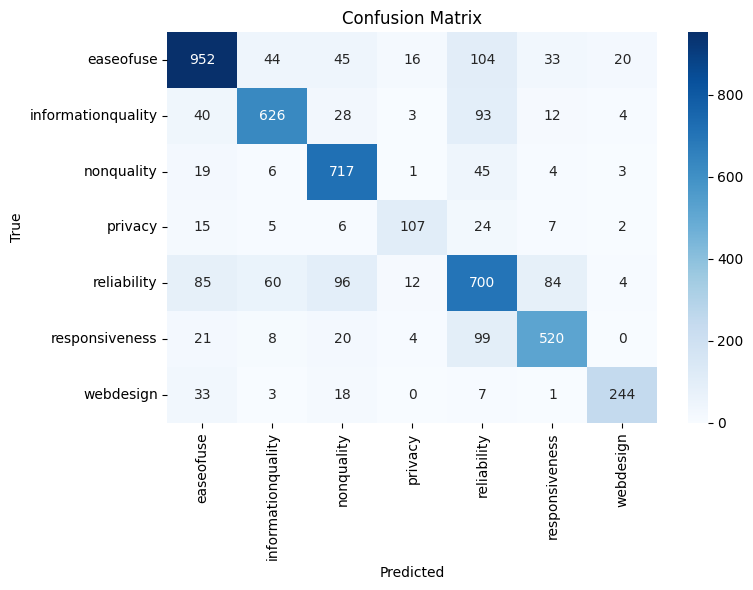

In [28]:
# 9. Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [29]:
# 10. Akurasi per kelas
label_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
accuracy_per_label = correct_counts / label_counts

In [30]:
# Gabungkan dengan classification report
report_dict = classification_report(y, y_pred, target_names=le.classes_, output_dict=True)
df_per_label = pd.DataFrame(report_dict).transpose().loc[le.classes_]
df_per_label['accuracy'] = accuracy_per_label

print("\n=== METRIK PER KELAS ===")
print(df_per_label[['precision', 'recall', 'f1-score', 'accuracy']])


=== METRIK PER KELAS ===
                    precision    recall  f1-score  accuracy
easeofuse            0.817167  0.784185  0.800336  0.784185
informationquality   0.832447  0.776675  0.803594  0.776675
nonquality           0.770968  0.901887  0.831304  0.901887
privacy              0.748252  0.644578  0.692557  0.644578
reliability          0.652985  0.672430  0.662565  0.672430
responsiveness       0.786687  0.773810  0.780195  0.773810
webdesign            0.880866  0.797386  0.837050  0.797386
